In [72]:
import glob
import os
import pandas as pd
import numpy as np
import joblib
import sklearn
import json
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [30]:
model_dir = '../models/sklearn/'
train_result_dir = '../data/train_results/'

model_dic = {}
species = glob.glob(f'{model_dir}/*')
for i in species:
    model_dic[os.path.basename(i)] = []
    all_models = glob.glob(f'{model_dir}/{os.path.basename(i)}/*.joblib')
    for x in all_models:
        to = os.path.basename(x).split('_')
        meta_dic = {
            'train_site': [to[2]],
            'test_site': [to[5]],
            'ML': [to[7]],
            'species': ['_'.join(to[9:10])],
            'antibiotics': [to[12]],
            'seed': [to[14]],
            'model': joblib.load(x)
        }
        train_result_path = os.path.join(train_result_dir, meta_dic['ML'][0], os.path.basename(x).rstrip('_model.joblib')+'.json')
        if os.path.exists(train_result_path):
            try:
                train_result_path = os.path.join(train_result_dir, meta_dic['ML'][0], os.path.basename(x).rstrip('_model.joblib')+'.json')
                print(train_result_path)
                with open(train_result_path, 'r') as openfile:
                    # Reading from json file
                    json_object = json.load(openfile)
                meta_dic['test_prob'] = [np.array(json_object['y_score'])]
                meta_dic['test_true'] = [np.array(json_object['y_test'])]
            except:
                pass
        model_dic[os.path.basename(i)].append(meta_dic)

model_dic

../data/train_results/lr/Train_site_UMG-0_Test_site_UMG-0_Model_lr_Species_Escherichia_coli_Antibiotic_Ampicillin_Seed_35.json


{'Escherichia_coli': [{'train_site': ['UMG-0'],
   'test_site': ['UMG-0'],
   'ML': ['lr'],
   'species': ['Escherichia'],
   'antibiotics': ['Ampicillin'],
   'seed': ['35'],
   'model': Pipeline(steps=[('scaler', StandardScaler()),
                   ('lr',
                    LogisticRegression(C=np.float64(0.01), class_weight='balanced',
                                       max_iter=500, penalty='l1', random_state=35,
                                       solver='saga'))]),
   'test_prob': [array([[0.42850039, 0.57149961],
           [0.36755666, 0.63244334],
           [0.38899207, 0.61100793],
           ...,
           [0.60616834, 0.39383166],
           [0.35280198, 0.64719802],
           [0.49621056, 0.50378944]])],
   'test_true': [array([1, 1, 1, ..., 0, 1, 1])]}],
 'Staphylococcus_aureus': [],
 'Klebsiella_pneumoniae': [],
 'Quarto': []}

File scan done.
New bin file: ../data/binned_6000/Escherichia_coli/example1.txt found.
TtestResult(statistic=np.float64(-20.454398806362217), pvalue=np.float64(4.978110067041229e-79), df=np.int64(1097))
TtestResult(statistic=np.float64(-40.06589927365226), pvalue=np.float64(3.1172161100970937e-264), df=np.int64(2206))
TtestResult(statistic=np.float64(38.03829362159724), pvalue=np.float64(3.101085123735222e-203), df=np.int64(1108))
TtestResult(statistic=np.float64(40.065899273652235), pvalue=np.float64(3.1172161100985123e-264), df=np.int64(2206))
TtestResult(statistic=np.float64(-20.454398806362217), pvalue=np.float64(4.978110067041229e-79), df=np.int64(1097))
TtestResult(statistic=np.float64(-40.06589927365226), pvalue=np.float64(3.1172161100970937e-264), df=np.int64(2206))
TtestResult(statistic=np.float64(38.03829362159724), pvalue=np.float64(3.101085123735222e-203), df=np.int64(1108))
TtestResult(statistic=np.float64(40.065899273652235), pvalue=np.float64(3.1172161100985123e-264), df

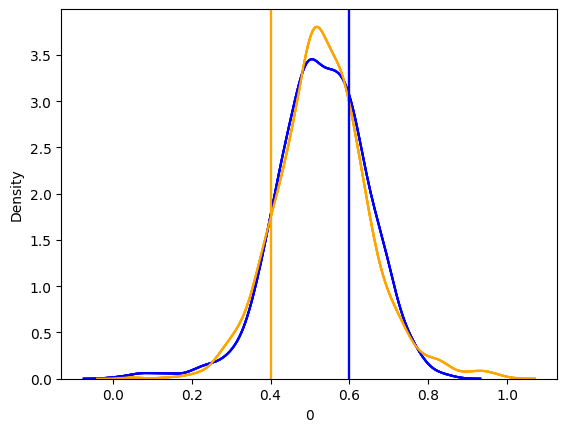

In [81]:
def ML_model_run(model_dic: dict, bin_filepath: str, species: str) -> pd.DataFrame:
    vec = pd.read_csv(bin_filepath, sep=' ', index_col=False, header=None).to_numpy()
    vec = vec.T

    result = pd.DataFrame()
    list_of_models = model_dic[species]
    for model_item in list_of_models:
        model = model_item['model']
        meta_data = model_item.copy()
        del meta_data['model']
        result_row = pd.DataFrame.from_dict(meta_data)
        pred = model.predict_proba(vec)[0]
        result_row['S'] = pred[0]
        result_row['R'] = pred[1]
        result = pd.concat([result, result_row], axis = 0)
        dist_x = pd.DataFrame(meta_data['test_prob'][0])
        dist_x_true = meta_data['test_true'][0]
        #dist_x = dist_x[dist_x_true==1]
        
        dist_x['label'] = dist_x_true
        sns.kdeplot(data=dist_x[dist_x_true==0].iloc[:,0], color="blue")
        sns.kdeplot(data=dist_x[dist_x_true==1].iloc[:,1], color="orange")

        #sns.ecdfplot(data=dist_x.iloc[:,0], color='black', ylim=(0.5,1))
        plt.axvline(x=pred[0], color='blue')
        print(stats.ttest_1samp(dist_x[dist_x_true==0].iloc[:,0], pred[0]))
        print(stats.ttest_1samp(dist_x.iloc[:,0], pred[0]))
        
        #sns.ecdfplot(data=dist_x.iloc[:,1], color='red')
        plt.axvline(x=pred[1], color='orange')
        print(stats.ttest_1samp(dist_x[dist_x_true==1].iloc[:,1], pred[1]))
        print(stats.ttest_1samp(dist_x.iloc[:,1], pred[1]))

    return result


def folder_scan(raw_dir: str) -> dict:
    file_exist_dic = {}
    raw_file_path = os.path.join(raw_dir, '*', '*')
    raw_file_list = glob.glob(raw_file_path)
    for filepath in raw_file_list:
        species_name, sample_number = filepath.split(os.sep)[-2:]
        if species_name not in file_exist_dic.keys():
            file_exist_dic[species_name] = set()
        file_exist_dic[species_name].add(sample_number)
    print(f'File scan done.')
    
    return file_exist_dic


def preprocessing(input_dir: str, output_dir: str, file_exist_dic: dict) -> None:
    for species in file_exist_dic.keys():
        raw_path_species = os.path.join(input_dir, species)
        preprocessed_path = os.path.join(output_dir, species)
        os.makedirs(preprocessed_path, exist_ok=True)
        for sample_number in file_exist_dic[species]:
            raw_path = os.path.join(raw_path_species, sample_number)
            preprocessed_filepath = os.path.join(preprocessed_path, sample_number)

            if os.path.exists(preprocessed_filepath):
                #print(f'Preprocessing {preprocessed_filepath} already exist.')
                continue
            
            print(f'New bin file: {raw_path} found.')
            pred_res = ML_model_run(model_dic, raw_path, species)

            try:
                pred_res = ML_model_run(model_dic, raw_path, species)
                print(f'ML prediction {preprocessed_filepath} done.')
            except:
                print(f'ML prediction of {raw_path} fail.')

    return 


bin_size = 6000
binned_dir = os.path.join('..', 'data', f'binned_{str(bin_size)}')
bin_files = folder_scan(binned_dir)

results_dir = os.path.join('..', 'results')


preprocessing(binned_dir, results_dir, bin_files)